In [1]:
 pip install biopython

Note: you may need to restart the kernel to use updated packages.


In [2]:
from Bio import SeqIO

# Load the FASTA file
with open("/Users/macbookpro/Downloads/sequence.fasta", "r") as fasta_file:
    fasta_record = SeqIO.read(fasta_file, "fasta")
    sequence = str(fasta_record.seq)  # Convert to a string

# Load the GenBank file
with open("/Users/macbookpro/Downloads/sequence.gb", "r") as gb_file:
    gb_record = SeqIO.read(gb_file, "genbank")

# Print basic info
print("Sequence ID:", fasta_record.id)
print("Sequence length:", len(sequence))
print("Number of features:", len(gb_record.features))

Sequence ID: NC_090774.1
Sequence length: 4198534
Number of features: 5298


In [3]:
# Extract coding regions (CDS)
coding_sequences = []
for feature in gb_record.features:
    if feature.type == "CDS":  # Look for coding sequences
        start = feature.location.start
        end = feature.location.end
        coding_sequences.append(sequence[start:end])

# Extract noncoding regions (everything else)
noncoding_sequences = []
current_start = 0
for feature in gb_record.features:
    if feature.type == "CDS":
        noncoding_sequences.append(sequence[current_start:feature.location.start])
        current_start = feature.location.end
noncoding_sequences.append(sequence[current_start:])  # Add the last segment

# Convert to strings
coding_sequence = "".join(coding_sequences)
noncoding_sequence = "".join(noncoding_sequences)

# Print lengths to check
print("Coding length:", len(coding_sequence))
print("Noncoding length:", len(noncoding_sequence))

Coding length: 2292132
Noncoding length: 1906542


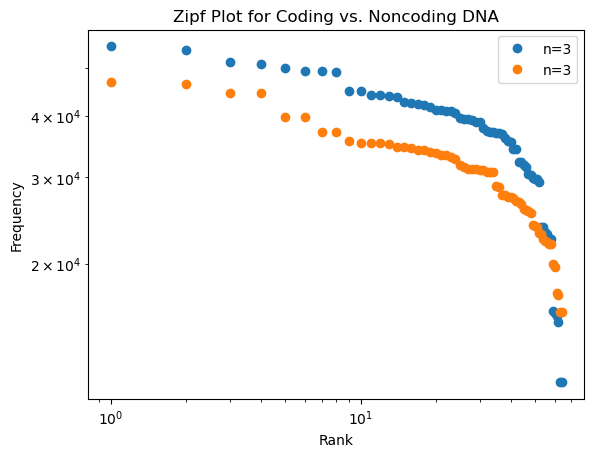

In [4]:
from collections import Counter
import matplotlib.pyplot as plt

def zipf_analysis(sequence, n=3):
    # Extract n-tuples
    n_tuples = [sequence[i:i+n] for i in range(len(sequence) - n + 1)]
    
    # Count frequencies
    freq = Counter(n_tuples)
    
    # Sort by frequency
    sorted_freq = sorted(freq.values(), reverse=True)
    
    # Assign ranks
    ranks = range(1, len(sorted_freq) + 1)
    
    # Plot
    plt.loglog(ranks, sorted_freq, 'o', label=f'n={n}')

# Analyze coding sequence
zipf_analysis(coding_sequence, n=3)

# Analyze noncoding sequence
zipf_analysis(noncoding_sequence, n=3)

# Add labels and legend
plt.xlabel('Rank')
plt.ylabel('Frequency')
plt.title('Zipf Plot for Coding vs. Noncoding DNA')
plt.legend()
plt.show()

In [4]:
from Bio import SeqIO
from collections import Counter
import numpy as np
import math
from scipy.stats import linregress

# === 1. Load sequences ===
fasta_path = "/Users/macbookpro/Downloads/sequence.fasta"
gb_path = "/Users/macbookpro/Downloads/sequence.gb"

with open(fasta_path) as fasta_file:
    fasta_record = SeqIO.read(fasta_file, "fasta")
    sequence = str(fasta_record.seq)

with open(gb_path) as gb_file:
    gb_record = SeqIO.read(gb_file, "genbank")

# === 2. Extract coding and non-coding regions ===
coding_sequences = []
for feature in gb_record.features:
    if feature.type == "CDS":
        start = int(feature.location.start)
        end = int(feature.location.end)
        coding_sequences.append(sequence[start:end])
coding_sequence = "".join(coding_sequences)

noncoding_sequences = []
current_start = 0
for feature in gb_record.features:
    if feature.type == "CDS":
        noncoding_sequences.append(sequence[current_start:int(feature.location.start)])
        current_start = int(feature.location.end)
noncoding_sequences.append(sequence[current_start:])
noncoding_sequence = "".join(noncoding_sequences)


# === 3. Functions for calculations ===
def zipf_exponent(seq, n=3):
    """Calculates Zipf's exponent via log-log regression."""
    ngrams = [seq[i:i+n] for i in range(len(seq)-n+1)]
    freq = Counter(ngrams)
    sorted_freq = sorted(freq.values(), reverse=True)
    ranks = np.arange(1, len(sorted_freq) + 1)
    log_ranks = np.log(ranks)
    log_freq = np.log(sorted_freq)
    slope, intercept, r_value, p_value, std_err = linregress(log_ranks, log_freq)
    return -slope  # Zipf exponent

def hurst_exponent(seq):
    """Estimates the Hurst exponent via R/S analysis."""
    # Convert to binary sequence: A/T=0, G/C=1 (example mapping)
    mapping = {'A': 0, 'T': 0, 'G': 1, 'C': 1}
    data = np.array([mapping.get(base, 0) for base in seq])
    N = len(data)
    T = np.arange(10, N // 2, N // 20)  # window sizes
    RS = []
    for t in T:
        chunks = N // t
        rs_vals = []
        for i in range(chunks):
            segment = data[i*t:(i+1)*t]
            mean_seg = np.mean(segment)
            Z = np.cumsum(segment - mean_seg)
            R = np.max(Z) - np.min(Z)
            S = np.std(segment)
            if S != 0:
                rs_vals.append(R/S)
        if rs_vals:
            RS.append(np.mean(rs_vals))
    slope, _, _, _, _ = linregress(np.log(T[:len(RS)]), np.log(RS))
    return slope

def shannon_entropy(seq, n=1):
    """Calculates Shannon entropy for n-grams."""
    ngrams = [seq[i:i+n] for i in range(len(seq)-n+1)]
    freq = Counter(ngrams)
    total = sum(freq.values())
    probs = [count / total for count in freq.values()]
    entropy = -sum(p * math.log2(p) for p in probs)
    return entropy


# === 4. Perform calculations ===
for name, seq in [("Coding", coding_sequence), ("Noncoding", noncoding_sequence)]:
    z_exp = zipf_exponent(seq, n=3)
    h_exp = hurst_exponent(seq)
    s_ent = shannon_entropy(seq, n=1)
    print(f"{name} region:")
    print(f"  Zipf exponent: {z_exp:.4f}")
    print(f"  Hurst exponent: {h_exp:.4f}")
    print(f"  Shannon entropy: {s_ent:.4f}")
    print("-" * 40)


Coding region:
  Zipf exponent: 0.2938
  Hurst exponent: 0.6773
  Shannon entropy: 1.9976
----------------------------------------
Noncoding region:
  Zipf exponent: 0.2385
  Hurst exponent: 0.6811
  Shannon entropy: 1.9929
----------------------------------------
